In [0]:

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import re
from datetime import datetime
import pandas as pd
import sqlite3
import os
import math
import numpy as np
import nltk
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
# Importing Kears libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout
np.random.seed(7)

Using TensorFlow backend.


#### Upload csv file into colab 

In [0]:
# Reference link 
# https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1_T24w8Ml_Q7inaHDLgCRGdwg7OHESJHt'

In [5]:
fluff, id = link.split('=')
id = '1_T24w8Ml_Q7inaHDLgCRGdwg7OHESJHt'
print(id)

1_T24w8Ml_Q7inaHDLgCRGdwg7OHESJHt


In [0]:
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Reviews.csv')

In [7]:
rev = pd.read_csv('Reviews.csv')
#Dataset Dimensions and columns
print(rev.shape)
print(rev.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
#Fuction used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty):
  fig =plt.figure(facecolor = 'g', edgecolor='k')
  plt.plot(x, vy, 'b', label='Validation Loss')
  plt.plot(x, ty, 'r', label='Train Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Categorical Crossentropy Loss')
  plt.legend()
  plt.grid()
  plt.show()

#### Pre-processing

In [0]:
#Defining reviews with score > 3 Positive Rating, reviews with < 3 Negative rating
def score_part(x):
  if x < 3:
      return 0
  return 1

actualScore = rev['Score']
New_score = actualScore.map(score_part)
rev['Score'] = New_score

In [10]:
print(rev.shape)
rev.head(3)

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=rev.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(rev['Id'].size*1.0)*100

final.shape
print(final.shape)

(393931, 10)


In [0]:
final = final[final['ProductId'] != '7310172001']

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(rev['Id'].size*1.0)*100

69.26875349632512

#### Text Preprocessing

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
#words_to_keep = set(('not'))
#stop -= words_to_keep

sno = nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence): #function to clean any HTML Tags
    cleanr = re.compile('<.*?>$< /><')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean any word of punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ', cleaned)
    return cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase.

'''Pre processing of text data:It is cleaning and flitering text'''
i=0
str1=' '
global final_string
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1


#### Loading processed text into pickle file

In [0]:
pickle_path_final_string='final_string.pkl'
final_string_file=open(pickle_path_final_string,'wb')
pickle.dump(final_string,final_string_file)
final_string_file.close()

In [0]:
pickle_path_final_string='final_string.pkl'
final_string_unpkl=open(pickle_path_final_string,'rb')
final_string=pickle.load(final_string_unpkl)

In [18]:
final['cleanedText']=final_string
final['cleanedText']=final['cleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (393761, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,saw charm rose pep chicken chicken great book ...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movi sound track sing along carol king gre...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertain rhyme catchi illustr imagin fit righ...


In [0]:
final = final[0:50000] #taking the first 50k reviews

In [0]:
#Time Based Splitting, sorted in ascending order
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
X = time_sorted_data['cleanedText'].values
y = time_sorted_data['Score']

In [44]:
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print(len(X_train))
print(len(X_test))

30000
20000


In [45]:
#https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= 5000)
tokenizer.fit_on_texts(X_train)
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)
print(X_train[0])

took forev get cooki paid express ship got product week later never order compani


In [46]:
print(tokenizer.word_index)

{'like': 1, 'tea': 2, 'tast': 3, 'use': 4, 'product': 5, 'good': 6, 'one': 7, 'love': 8, 'flavor': 9, 'great': 10, 'tri': 11, 'get': 12, 'make': 13, 'food': 14, 'dog': 15, 'would': 16, 'time': 17, 'buy': 18, 'order': 19, 'realli': 20, 'dont': 21, 'amazon': 22, 'much': 23, 'eat': 24, 'find': 25, 'also': 26, 'well': 27, 'littl': 28, 'day': 29, 'even': 30, 'best': 31, 'bag': 32, 'treat': 33, 'price': 34, 'store': 35, 'year': 36, 'ive': 37, 'coffe': 38, 'box': 39, 'better': 40, 'cat': 41, 'mix': 42, 'sauc': 43, 'recommend': 44, 'look': 45, 'work': 46, 'drink': 47, 'want': 48, 'first': 49, 'hot': 50, 'chocol': 51, 'give': 52, 'found': 53, 'bought': 54, 'brand': 55, 'purchas': 56, 'think': 57, 'made': 58, 'high': 59, 'sugar': 60, 'way': 61, 'need': 62, 'packag': 63, 'know': 64, 'two': 65, 'water': 66, 'add': 67, 'review': 68, 'thing': 69, 'sinc': 70, 'ship': 71, 'sweet': 72, 'differ': 73, 'could': 74, 'still': 75, 'say': 76, 'mani': 77, 'cup': 78, 'never': 79, 'lot': 80, 'enjoy': 81, 'got': 

In [0]:
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

In [48]:
#Split the Dataset into Train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(review_data, y, test_size=0.3, random_state=42)
print("length of X_train :", len(X_train))
print("length of X_test :", len(X_test))
print("shape of Y_train :", Y_train.shape)
print("shape of Y_test :", Y_test.shape)

length of X_train : 35000
length of X_test : 15000
shape of Y_train : (35000,)
shape of Y_test : (15000,)


#### Conversion of Reviews into IMDB Dataset

In [49]:
#Time Based Splitting, sorted in ascending order
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
x = time_sorted_data['cleanedText'].values
y = time_sorted_data['Score']

count_vect = CountVectorizer()
count_vect.fit(x)
vocabulary = count_vect.get_feature_names()
print('No of words in vocabulary : ', len(vocabulary))


No of words in vocabulary :  27926


In [34]:
#store words into vocab
word_dict = dict()
index = 0
for words in x:
  for word in words.split():
    word_dict.setdefault(word, [])
    word_dict[word].append(index)
    index+=1
# frequency for each word in the vocab
freq = []
for w in vocabulary:
  freq.append(len(word_dict[w]))
print('completed')

completed


In [0]:
#sorting frequency in descending order
new_index = np.argsort(np.array(freq))[::-1]
#Giving Rank to frequency
word_rank = dict()
rank=1
for i in new_index:
  word_rank[vocabulary[i]]=rank
  rank+=1

#### Text Reviews into IMDB Format

In [0]:
review_data = []
for sent in x:
  row=[]
  for word in sent.split():
    if len(word)>1:
      row.append(word_rank[word])
  review_data.append(row)

In [37]:
print(review_data[0])

[9329, 28, 881, 13, 449, 1994, 2545, 9290, 1495, 1376, 529, 101, 2980, 7443, 676, 702, 7281, 2389, 9684, 8, 148, 867, 881, 1032, 2586, 1113, 881, 1547, 2089, 449, 76, 224, 9290, 1275, 1702]


In [38]:
# truncate and/or pad input sequences
max_review_length = 120
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(35000, 120)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0  1928    33    48  1346
   218   272  2137   398    83   387   978  1052  1416   717   274 23227
  1320    29   533   658    86    88   760    12  2639    80    33   211
    17   203    62   241   387   978   132  2137    16   100    12    33
    52    21   656   946   131   684   726   215   258   258    81   880]


In [40]:
len_vocab = len(vocabulary)+1
print(len_vocab)

27927


#### 2 RNN with 2 LSTM layers

In [0]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers.normalization  import BatchNormalization
from keras.models import Sequential
embedding_len = 32
lstm_2=Sequential()
lstm_2.add(Embedding(len_vocab, embedding_len, input_length=max_review_length))
lstm_2.add(Dropout(0.15))

#1st LSTM Layer
lstm_2.add(LSTM(100, return_sequences=True, dropout=0.15, recurrent_dropout=0.25))
lstm_2.add(BatchNormalization())

#2nd LSTM Layer
lstm_2.add(LSTM(100, dropout=0.15, recurrent_dropout=0.25))
#lstm_2.add(BatchNormalization())

#output layer
lstm_2.add(Dense(1, activation='sigmoid'))

print(lstm_2.summary())

#Compile Model
lstm_2.compile(loss='binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
history_2 = lstm_2.fit(X_train, Y_train, nb_epoch=10,
                      batch_size=512, verbose=1,
                      validation_data=(X_test, Y_test))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 32)           893664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 100)          53200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 100)          400       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
T

Test score: 0.41556513959964114
Test Accuracy : 0.8844000000317891


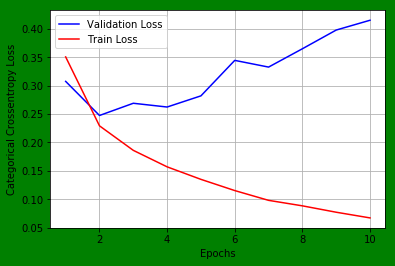

In [0]:
#Evaluate Model with plots
score = lstm_2.evaluate(X_test,Y_test,verbose=0)
test_score_lstm_2=score[0]
test_accuracy_lstm_2=score[1]
train_accuracy_lstm_2=max(history_2.history['acc'])
print('Test score:', test_score_lstm_2)
print('Test Accuracy :', test_accuracy_lstm_2)

x =list(range(1,11))
#validation loss
vy = history_2.history['val_loss']
# train loss
ty = history_2.history['loss']
plt_dynamic(x, vy, ty)

#### Obsrevation:
* Implemented 2RNN with 2LSTM layer observed overfitting at epochs = 10
* Train Loss Slopes downward where validation loss hits at inflection point .
* After inflection validation loss continue to increase.

#### RNN with 2 LSTM Layers without BatchNormalization and Dropout

In [0]:
from keras.layers.normalization  import BatchNormalization
embedding_len = 32
lstm_3=Sequential()
lstm_3.add(Embedding(len_vocab, embedding_len, input_length=max_review_length))
#lstm_2.add(Dropout(0.15))

#1st LSTM Layer
lstm_3.add(LSTM(100))
#lstm_2.add(BatchNormalization())

#2nd LSTM Layer
#lstm_3.add(LSTM(80))
#lstm_2.add(BatchNormalization())

#output layer
lstm_3.add(Dense(1, activation='sigmoid'))

print(lstm_3.summary())

#Compile Model
lstm_3.compile(loss='binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
history_3 = lstm_3.fit(X_train, Y_train, nb_epoch=10,
                      batch_size=512, verbose=1,
                      validation_data=(X_test, Y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 32)           893664    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 946,965
Trainable params: 946,965
Non-trainable params: 0
_________________________________________________________________
None
Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 77s 2ms/step - loss: 0.4345 - acc: 0.8539 - val_loss: 0.3408 - val_acc: 0.8597
Epoch 2/10
35000/35000 [==============================] - 75s 2ms/step - loss: 0.2614 - acc: 0.8890 - val_loss: 0.2483 - val_acc: 0.8984
Epoch 3/10
35000/35000 [=========================

Test score: 0.3501540129343669
Test Accuracy : 0.8733333333015442


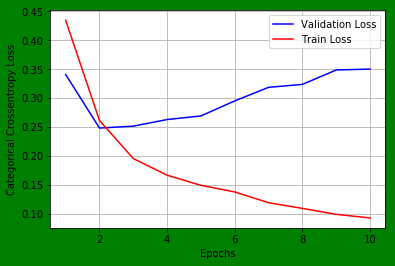

In [0]:
#Evaluate Model with plots
score = lstm_3.evaluate(X_test,Y_test,verbose=0)
test_score_lstm_3=score[0]
test_accuracy_lstm_3=score[1]
train_accuracy_lstm_3=max(history_3.history['acc'])
print('Test score:', test_score_lstm_3)
print('Test Accuracy :', test_accuracy_lstm_3)

x =list(range(1,11))
#validation loss
vy = history_3.history['val_loss']
# train loss
ty = history_3.history['loss']
plt_dynamic(x, vy, ty)

#### Observation:
 * Observed Same with 2RNN without BacthNorm and Dropout also.

#### 3 RNN with 4 LSTM layer

In [0]:
from keras.layers.normalization  import BatchNormalization
embedding_len = 32
lstm_4=Sequential()
lstm_4.add(Embedding(len_vocab, embedding_len, input_length=max_review_length))
lstm_4.add(Dropout(0.25))

#1st LSTM Layer
lstm_4.add(LSTM(100, return_sequences=True, dropout=0.15, recurrent_dropout=0.25))

#2nd LSTM Layer
lstm_4.add(LSTM(80, return_sequences=True, dropout=0.15, recurrent_dropout=0.25))
lstm_4.add(BatchNormalization())

#3rd LSTM Layer
lstm_4.add(LSTM(50, dropout=0.15,return_sequences=True, recurrent_dropout=0.25))
lstm_4.add(BatchNormalization())

#4th LSTM Layer
lstm_4.add(LSTM(40,dropout=0.15))
lstm_4.add(BatchNormalization())

#output layer
lstm_4.add(Dense(1, activation='sigmoid'))


print(lstm_4.summary())

#Compile Model
lstm_4.compile(loss='binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
history_4 = lstm_4.fit(X_train, Y_train, nb_epoch=10,
                      batch_size=512, verbose=1,
                      validation_data=(X_test, Y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 32)           893664    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 120, 100)          53200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 120, 80)           57920     
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 80)           320       
_________________________________________________________________
lstm_6 (LSTM)                (None, 120, 50)           26200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 120, 50)          

Test score: 0.3368108386516571
Test Accuracy : 0.8909333333333334


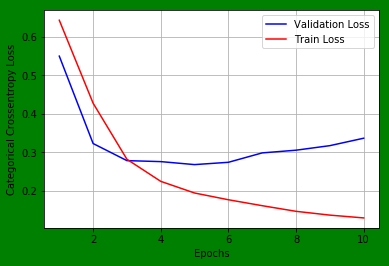

In [0]:
#Evaluate Model with plots
score = lstm_4.evaluate(X_test,Y_test,verbose=0)
test_score_lstm_4=score[0]
test_accuracy_lstm_4=score[1]
train_accuracy_lstm_4=max(history_4.history['acc'])
print('Test score:', test_score_lstm_4)
print('Test Accuracy :', test_accuracy_lstm_4)

x =list(range(1,11))
#validation loss
vy = history_4.history['val_loss']
# train loss
ty = history_4.history['loss']
plt_dynamic(x, vy, ty)

#### Observation:
* In the case of 3RNN 4 Lstm layered architecture slight improvement observed with increased no of LSTM layers.
* In the Train Loss And Validation Loss.

#### 4 RNN with 5 LSTM Layers

In [0]:
from keras.layers.normalization  import BatchNormalization
embedding_len = 32
lstm_5=Sequential()
lstm_5.add(Embedding(len_vocab, embedding_len, input_length=max_review_length))
lstm_5.add(Dropout(0.45))

#1st LSTM Layer
lstm_5.add(LSTM(120, return_sequences=True, dropout=0.35, recurrent_dropout=0.25))

#2nd LSTM Layer
lstm_5.add(LSTM(100, return_sequences=True, dropout=0.35, recurrent_dropout=0.35))
lstm_5.add(BatchNormalization())

#3rd LSTM Layer
lstm_5.add(LSTM(100, return_sequences=True, dropout=0.35, recurrent_dropout=0.35))
lstm_5.add(BatchNormalization())

#4th LSTM Layer
lstm_5.add(LSTM(80,return_sequences=True, dropout=0.35, recurrent_dropout=0.35))
lstm_5.add(BatchNormalization())

#5th LSTM Layer
lstm_5.add(LSTM(60, dropout=0.35, recurrent_dropout=0.35))
lstm_5.add(BatchNormalization())

#output layer
lstm_5.add(Dense(1, activation='sigmoid'))

print(lstm_5.summary())

#Compile Model
lstm_5.compile(loss='binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
history_5 = lstm_5.fit(X_train, Y_train, nb_epoch=10,
                      batch_size=512, verbose=1,
                      validation_data=(X_test, Y_test))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 32)           893664    
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 120, 120)          73440     
_________________________________________________________________
lstm_9 (LSTM)                (None, 120, 100)          88400     
_________________________________________________________________
batch_normalization_5 (Batch (None, 120, 100)          400       
_________________________________________________________________
lstm_10 (LSTM)               (None, 120, 100)          80400     
_________________________________________________________________
batch_normalization_6 (Batch (None, 120, 100)         

Test score: 0.4096281182289124
Test Accuracy : 0.8595333333333334


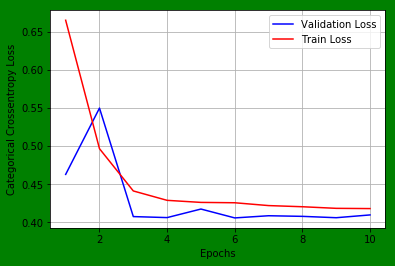

In [0]:
#Evaluate Model with plots
score = lstm_5.evaluate(X_test,Y_test,verbose=0)
test_score_lstm_5=score[0]
test_accuracy_lstm_5=score[1]
train_accuracy_lstm_5=max(history_5.history['acc'])
print('Test score:', test_score_lstm_5)
print('Test Accuracy :', test_accuracy_lstm_5)

x =list(range(1,11))
#validation loss
vy = history_5.history['val_loss']
# train loss
ty = history_5.history['loss']
plt_dynamic(x, vy, ty)

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["RNN With Number Of Hidden Layers", "BatchNormal", "Dropout", "Accuracy", "Loss"]

x.add_row(["2 RNN 2 LSTM Layers", 'YES', 0.15, 0.905, 0.108])
x.add_row(["2 RNN Without BatchNorm, Dropout", 'NO', 'NO', 0.902, 0.113])
x.add_row(["3 RNN 4 LSTM Layers", 'YES', 0.15, 0.902, 0.141])
x.add_row(["4 RNN 5 LSTM Layers", 'YES', 0.35, 0.886, 0.415])
print(x)

+----------------------------------+-------------+---------+----------+-------+
| RNN With Number Of Hidden Layers | BatchNormal | Dropout | Accuracy |  Loss |
+----------------------------------+-------------+---------+----------+-------+
|       2 RNN 2 LSTM Layers        |     YES     |   0.15  |  0.905   | 0.108 |
| 2 RNN Without BatchNorm, Dropout |      NO     |    NO   |  0.902   | 0.113 |
|       3 RNN 4 LSTM Layers        |     YES     |   0.15  |  0.902   | 0.141 |
|       4 RNN 5 LSTM Layers        |     YES     |   0.35  |  0.886   | 0.415 |
+----------------------------------+-------------+---------+----------+-------+


In [0]:
#### Conclusions:
* Applied LSTM(Long Short Term Memory) on Amazon Fine Food Reviews DataSet, Using Google Colab environment.
* Upload review text zip file into colab.
* preprocessing review text with score > 3 positive rating, score<3 negative rating.
* Using pickle file to store preprocessed review text for future purpose.
* Converion of Reviews into IMDB format needs to create vocabulary, frequency for each word.
* sorted in descending order for each word with index ranking.
* Implemented 2RNN with 2LSTM layer observed overfitting at epochs = 10
* Train Loss Slopes downward where validation loss hits at inflection point .
* After inflection validation loss continue to increase.
* Observed Same with 2RNN without BacthNorm and Dropout also.
* In the case of 3RNN 4 Lstm layered architecture slight improvement observed with increased no of LSTM layers.
* In the Train Loss And Validation Loss.
* For 4RNN 5LSTM layered Architecture changed dropout=0.35 observed more curved layer of validation loss.
* With increase in no of layers, at epoch =10 train loss is stable.
* From above PrettyTable we can see the results for each layer.